In [1]:
""" 本部分代码：用编码器、VAE进行编码。

"""
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Concatenate, Flatten, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy, kullback_leibler_divergence
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import json
import glob
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarn

In [2]:
import os
path = os.getcwd()+'/data/icons'
def load_icons(train_size=0.85):
    icon_index = json.load(open(path+'/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = path+'/png32/%s.png' % icon['name']
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
    x = np.asarray(x) / 255
    x_train, x_val = train_test_split(x, train_size=train_size)
    return x_train, x_val

x_train, x_test = load_icons()
x_train.shape, x_test.shape

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((5938, 32, 32, 1), (1048, 32, 32, 1))

In [3]:
x_train.shape

(5938, 32, 32, 1)

In [5]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)

    for i in range(5):
        x = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        channels //= 2
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
plot_model(autoencoder, to_file='autoencoder14.2.png',show_shapes=True)
autoencoder.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 4)    40          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 4)    20          input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 32, 32, 8)    0           conv2d_17[0][0]                  
                                                                 conv2d_18[0][0]                  
__________

In [5]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 5938 samples, validate on 1048 samples
Epoch 1/100
5938/5938 [==============================] - 5s 855us/step - loss: 0.5640 - val_loss: 0.5110
Epoch 2/100
5938/5938 [==============================] - 5s 871us/step - loss: 0.5123 - val_loss: 0.5168
Epoch 3/100
5938/5938 [==============================] - 5s 854us/step - loss: 0.5038 - val_loss: 0.4944
Epoch 4/100
5938/5938 [==============================] - 5s 848us/step - loss: 0.4933 - val_loss: 0.5058
Epoch 5/100
5938/5938 [==============================] - 5s 858us/step - loss: 0.4931 - val_loss: 0.4969
Epoch 6/100
5938/5938 [==============================] - 5s 861us/step - loss: 0.4900 - val_loss: 0.4889
Epoch 7/100
5938/5938 [==============================] - 5s 848us/step - loss: 0.4885 - val_loss: 0.4861
Epoch 8/100
5938/5938 [==============================] - 5s 849us/step - loss: 0.4856 - val_loss: 0.4855
Epoch 9/100
5938/5938 [==============================] - 5s 855us/step - loss: 0.4855 - val_loss: 0.4847
Epoch 1

KeyboardInterrupt: 

In [6]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

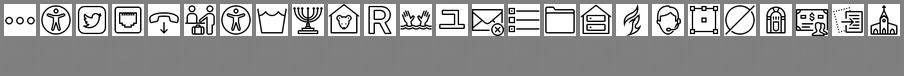

In [7]:
def decode_img(tile):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 36 + 4, 64 + 12), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 36 + 4, 4))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 36 + 4, 40))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [8]:
def augment(icons):
    aug_icons = []
    for icon in icons:
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
    return np.asarray(aug_icons)


In [9]:
x_train_aug = augment(x_train)
x_test_aug = augment(x_test)

In [10]:
x_train_aug.shape

(95008, 32, 32, 1)

In [ ]:
# from keras.callbacks import TensorBoard
# autoencoder = create_autoencoder()
# autoencoder.fit(x_train_aug, x_train_aug,
#                 epochs=100,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(x_test_aug, x_test_aug),
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [11]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

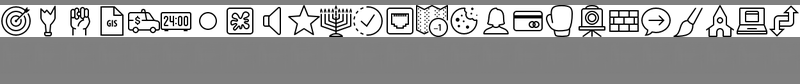

In [12]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [13]:
batch_size = 250
latent_space_depth = 128

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps

In [14]:
def VariationalAutoEncoder(num_pixels):
    
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)
    encoder_hidden = Flatten()(x)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.0001 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return binary_crossentropy(y_true, y_pred)

    def total_loss(y_true, y_pred):
        return reconstruction_loss(y_true, y_pred) + KL_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    decoder_in = Input(shape=(latent_space_depth,))

    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    e_x = Reshape((1, 1, latent_space_depth))(z)
    for i in range(5):
        conv = Conv2D(channels, (3, 3), activation='relu', padding='same')
        upsampling = UpSampling2D((2, 2))
        d_x = conv(d_x)
        d_x = upsampling(d_x)
        e_x = conv(e_x)
        e_x = upsampling(e_x)
        channels //= 2

    final_conv = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    auto_decoded = final_conv(e_x)
    decoder_out = final_conv(d_x)
    
    decoder = Model(decoder_in, decoder_out)    
    
    auto_encoder = Model(input_img, auto_decoded)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

var_auto_encoder, decoder = VariationalAutoEncoder(32)
plot_model(var_auto_encoder, to_file='var_auto_encoder14.2.png',show_shapes=True)
plot_model(decoder, to_file='decoder14.2.png',show_shapes=True)
var_auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 32, 32, 4)    40          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 32, 32, 4)    20          input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 32, 32, 8)    0           conv2d_33[0][0]                  
                                                                 conv2d_34[0][0]                  
__________

In [ ]:
decoder.summary()

In [ ]:
def truncate_to_batch(x):
    l = x.shape[0]
    return x[:l - l % batch_size, :, :, :]

x_train_trunc = truncate_to_batch(x_train)
x_test_trunc = truncate_to_batch(x_test)
x_train_trunc.shape, x_test_trunc.shape

In [ ]:
var_auto_encoder.fit(x_train_trunc, x_train_trunc, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_trunc, x_test_trunc))

In [ ]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height))


In [ ]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() * 1.4 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [ ]:
def truncate_to_batch(x):
    l = x.shape[0]
    return x[:l - l % batch_size, :, :, :]

x_train_trunc = truncate_to_batch(x_train_aug)
x_test_trunc = truncate_to_batch(x_test_aug)
x_train_trunc.shape, x_test_trunc.shape

var_auto_encoder.fit(x_train_trunc, x_train_trunc, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_trunc, x_test_trunc))

In [ ]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() * 1.2 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [ ]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[ - (i % 2) * (x - 4.5) / 3 + ((i + 1) % 2) * (y - 4.5) / 3
                            for i in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [ ]:
vec = np.asarray([[np.random.normal() 
                    for _ in range(latent_space_depth)]])
vec.shape

In [ ]:
vec

In [ ]:
np.asarray([[np.random.normal() 
                    for _ in range(latent_space_depth)]])